In [1]:
import pandas as pd
import numpy as np
from numpy.core.umath_tests import inner1d
import re
from math import floor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import SelectFromModel
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy.stats import skew, norm
from scipy.special import boxcox1p
import xgboost as xgb

/home/harry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  This is separate from the ipykernel package so we can avoid doing imports until


# 1. Read Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape

(3000, 23)

In [4]:
test.shape

(4398, 22)

In [5]:
#Save ID for submission
test_ID = test.id

# 2. Data Cleaning

There seems to be way more test cases than training cases ideally we'd want it the other way around. Lets clean up these data sets a bit.

In [6]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


The following columns can be dropped from our two datasets: belongs_to_collection, homepage, imdb_id, original_title, overview, poster_path, status, tagline.

In [7]:
drop_cols = ['belongs_to_collection','homepage','imdb_id','id','original_title','overview','poster_path','status','tagline','Keywords','crew','production_companies','production_countries','spoken_languages']

In [8]:
for col in drop_cols:
    train.drop(col, axis=1, inplace = True)
    test.drop(col, axis=1, inplace = True)

In [9]:
train.shape

(3000, 9)

In [10]:
test.shape

(4398, 8)

Now lets check null values and clean up the columns individually

In [11]:
train.isnull().sum()

budget                0
genres                7
original_language     0
popularity            0
release_date          0
runtime               2
title                 0
cast                 13
revenue               0
dtype: int64

In [12]:
test.isnull().sum()

budget                0
genres               16
original_language     0
popularity            0
release_date          1
runtime               4
title                 3
cast                 13
dtype: int64

## 2.1 genres
The genres column contains a dictionary for each entry. Lets first clean up the column to only have a string of genres. The dictionary contains each genre the film is apart of, some films are apart of more than one genre.

In [13]:
#function that cleans up the genre data; essentially it just extracts the values from the value-key pairs
def clean_genre(df):
    clean_list = []
    all_genres = df.genres
    for genre in all_genres:
        if genre is not np.nan:
            names = re.findall("name': '(.*?)'}", genre)
            clean_list.append(names)
        if genre is np.nan:
            clean_list.append('NULL')
    return clean_list

In [14]:
clean_genrelist = clean_genre(train)

In [15]:
train.genres = clean_genrelist

In [16]:
train.genres.head(5)

0                            [Comedy]
1    [Comedy, Drama, Family, Romance]
2                             [Drama]
3                   [Thriller, Drama]
4                  [Action, Thriller]
Name: genres, dtype: object

Now do the same for test dataset

In [17]:
clean_genrelist = clean_genre(test)

In [18]:
test.genres = clean_genrelist

In [19]:
test.genres.head(5)

0    [Adventure, Animation, Family, Fantasy]
1                  [Horror, Science Fiction]
2                          [Comedy, Romance]
3                      [Drama, War, Mystery]
4                     [History, Documentary]
Name: genres, dtype: object

Now that we've cleaned up the columns, lets do something about the **NULL** values. We can drop the train NULL values since there are only 7/3000 of them:

In [20]:
for x in range (0,len(train)):
    if train.loc[x,'genres'] == 'NULL':
        train.drop(x, axis=0, inplace = True)

In [21]:
train.shape

(2993, 9)

The 7 movies have been dropped from the train dataset, now lets manually edit the test dataset null genres

In [22]:
for x in range (0,len(test)):
    if test.loc[x,'genres'] == 'NULL':
        print(test.loc[x,:])

budget                                                               0
genres                                                            NULL
original_language                                                   en
popularity                                                    0.004425
release_date                                                    5/9/86
runtime                                                             95
title                                                Dangerously Close
cast                 [{'cast_id': 2, 'character': 'Randy McDevitt',...
Name: 73, dtype: object
budget                                                         8000000
genres                                                            NULL
original_language                                                   en
popularity                                                    0.406505
release_date                                                   2/18/83
runtime                                              

At Index **73** is the movie 'Dangerously Close', it was an Action Thriller

In [23]:
#so we dont get error messages when making the updates: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None

In [24]:
mylist = list(('Action','Thriller'))

In [25]:
test.genres[73] = mylist

In [26]:
test.genres[73]

['Action', 'Thriller']

At Index **793** is the movie 'Table for Five', it was a Drama

In [27]:
#function to fill in NULL genres for test df
def fill_genre(genres_list, index):
    genres = (list(genres_list))
    test.genres[index] = genres
    print(test.genres[index])    

In [28]:
fill_genre(['Action'],793)

['Action']


In [29]:
test.genres[793]

['Action']

At Index **910** is the movie 'Valentino', it was an adventure drama

In [30]:
fill_genre(['Adventure','Drama'],910)

['Adventure', 'Drama']


At Index **1221** is the movie 'Street Knight', it was an Action Adventure

In [31]:
fill_genre(['Action','Adventure'],1221)

['Action', 'Adventure']


At Index **1442** is the movie 'My Son', it was a Drama

In [32]:
fill_genre(['Drama'],1442)

['Drama']


At Index **1615** is the movie 'Nasha Russia', it was a Comedy

In [33]:
fill_genre(['Comedy'],1615)

['Comedy']


At Index **1964** is the movie 'Nasha Russia', it was a Crime Action film.

In [34]:
fill_genre(['Crime','Action'],1964)

['Crime', 'Action']


I cannot find the movie at index **2062**, so it will remain blank.

At Index **2118** is the movie 'Duniyadari', it was a Comedy Drama film.

In [35]:
fill_genre(['Comedy','Drama'],2118)

['Comedy', 'Drama']


At Index **2213** is the movie 'Praying with Lior', it was a Documentary film.

In [36]:
fill_genre(['Documentary'],2213)

['Documentary']


At Index **2251** is the movie 'Teddy Bears' Picnic', it was a Comedy film.

In [37]:
fill_genre(['Comedy'],2251)

['Comedy']


At Index **2519** is the movie 'Glukhar v kino', it was a Comedy film.

In [38]:
fill_genre(['Comedy'],2519)

['Comedy']


At Index **3449** is the movie 'Lucky Lady', it was a Drama Comedy film.


In [39]:
fill_genre(['Drama','Comedy'],3449)

['Drama', 'Comedy']


At Index **3485** is the movie 'Death of a Dynasty', it was a Comedy film.

In [40]:
fill_genre(['Comedy'],3485)

['Comedy']


At index **3564** is the movie 'Fahrenheit 9/11', it was a documentary

In [41]:
fill_genre(['Documentary'],3564)

['Documentary']


At index **3817** is the movie 'Miesten välisiä keskusteluja', it was a Drama

In [42]:
fill_genre(['Drama'],3817)

['Drama']


Check that only one NULL from indx **2062** remains:

In [43]:
for x in range (0,len(test)):
    if test.loc[x,'genres'] == 'NULL':
        print(test.loc[x,:])

budget                                                               0
genres                                                            NULL
original_language                                                   ro
popularity                                                     0.03856
release_date                                                  10/21/05
runtime                                                             95
title                                                               15
cast                 [{'cast_id': 1, 'character': 'Hilde', 'credit_...
Name: 2062, dtype: object


Lets give the movie at **2062** the mode genre, but first we have arrange our genres alphabetically so that a movie with genres ['comedy','horror'] are counted with ['horror','comedy'] 

In [44]:
for x in range (0,len(test)):
    genres = list(test.genres[x])
    test.genres[x] = sorted(genres)

In [45]:
#find the most popular 
test.genres.value_counts()

[Drama]                                                        350
[Comedy]                                                       295
[Drama, Romance]                                               202
[Comedy, Drama]                                                189
[Comedy, Drama, Romance]                                       167
[Comedy, Romance]                                              148
[Documentary]                                                   88
[Horror, Thriller]                                              84
[Crime, Drama, Thriller]                                        70
[Drama, Thriller]                                               69
[Crime, Drama]                                                  55
[Horror]                                                        53
[Action, Thriller]                                              48
[Action, Crime, Drama, Thriller]                                47
[Action, Crime, Thriller]                                     

In [46]:
fill_genre(['Drama'],2062)

['Drama']


In [47]:
#check that no more NULL genres exist
for x in range (0,len(test)):
    if test.loc[x,'genres'] == 'NULL':
        print(test.loc[x,:])

In [48]:
test.isnull().sum()

budget                0
genres                0
original_language     0
popularity            0
release_date          1
runtime               4
title                 3
cast                 13
dtype: int64

In [49]:
train.isnull().sum()

budget                0
genres                0
original_language     0
popularity            0
release_date          0
runtime               2
title                 0
cast                 13
revenue               0
dtype: int64

## 2.2 Cast
Movies with missing Cast values will be replaced with **'NONE'**

In [50]:
train.cast.fillna('NONE', inplace=True)

In [51]:
test.cast.fillna('NONE', inplace=True)

In [52]:
train.isnull().sum()

budget               0
genres               0
original_language    0
popularity           0
release_date         0
runtime              2
title                0
cast                 0
revenue              0
dtype: int64

In [53]:
test.isnull().sum()

budget               0
genres               0
original_language    0
popularity           0
release_date         1
runtime              4
title                3
cast                 0
dtype: int64

## 2.3 runtime
We will manually fill in the missing runtime values for test and train if we can.

In [54]:
train[train.runtime.isnull()]

,budget,genres,original_language,popularity,release_date,runtime,title,cast,revenue
1335,6000000,[Drama],ru,0.292296,10/29/07,NaN,Королёв,"[{'cast_id': 3, 'character': '–°–µ—Ä–≥–µ–π –ö–...",31000
2302,0,[Comedy],de,0.002229,3/14/96,NaN,Happy Weekend,"[{'cast_id': 0, 'character': 'Joachim Krippo',...",65335


In [55]:
#information googled
train.runtime[1335] = 130
train.runtime[2302] = 90

In [56]:
test[test.runtime.isnull()]

,budget,genres,original_language,popularity,release_date,runtime,title,cast
243,0,[Comedy],es,0.000464,3/20/81,NaN,La caliente niña Julietta,"[{'cast_id': 7, 'character': 'Julietta Santigo..."
1489,0,[Comedy],es,0.661399,6/6/14,NaN,"Pancho, el perro millonario","[{'cast_id': 3, 'character': 'Alberto', 'credi..."
1632,0,[Comedy],es,0.281500,11/3/78,NaN,Nunca en horas de clase,"[{'cast_id': 6, 'character': 'Susy', 'credit_i..."
3817,0,[Drama],fi,0.011427,1/4/13,NaN,Miesten välisiä keskusteluja,"[{'cast_id': 0, 'character': 'Kari Mairisaari'..."


In [57]:
#information googled
test.runtime[243] = 93
test.runtime[1489] = 91
test.runtime[1632] = 100
test.runtime[3817] = 116

In [58]:
test.isnull().sum()

budget               0
genres               0
original_language    0
popularity           0
release_date         1
runtime              0
title                3
cast                 0
dtype: int64

In [59]:
train.isnull().sum()

budget               0
genres               0
original_language    0
popularity           0
release_date         0
runtime              0
title                0
cast                 0
revenue              0
dtype: int64

## 2.3 Release Date
Theres just one missing release date from the test dataset which we can fill manually.

In [60]:
test[test.release_date.isnull()]

,budget,genres,original_language,popularity,release_date,runtime,title,cast
828,0,[Drama],en,0.009057,NaN,90.0,"Jails, Hospitals & Hip-Hop",[]


In [61]:
#information googled
test.release_date[828] = '05/01/00'

In [62]:
train.isnull().sum()

budget               0
genres               0
original_language    0
popularity           0
release_date         0
runtime              0
title                0
cast                 0
revenue              0
dtype: int64

In [63]:
test.isnull().sum()

budget               0
genres               0
original_language    0
popularity           0
release_date         0
runtime              0
title                3
cast                 0
dtype: int64

## 2.4 Title
We can drop this column because we only needed it to google missing information, it wont help with modelling.

In [64]:
train.drop('title', axis=1, inplace = True)
test.drop('title', axis=1, inplace = True)

In [65]:
test.isnull().sum()

budget               0
genres               0
original_language    0
popularity           0
release_date         0
runtime              0
cast                 0
dtype: int64

In [66]:
train.isnull().sum()

budget               0
genres               0
original_language    0
popularity           0
release_date         0
runtime              0
cast                 0
revenue              0
dtype: int64

# 3. Feature Engineering
## 3.1 Oringinal Language 
Since a big moajority (86% of the data according to kaggle) has english as the orignal language, I will breakdown the original language to either ENGLISH or FOREIGN and then get dummy variables for the two. 

In [67]:
test.head()

,budget,genres,original_language,popularity,release_date,runtime,cast
0,0,"[Adventure, Animation, Family, Fantasy]",ja,3.851534,7/14/07,90.0,"[{'cast_id': 3, 'character': 'Tonio', 'credit_..."
1,88000,"[Horror, Science Fiction]",en,3.559789,5/19/58,65.0,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc..."
2,0,"[Comedy, Romance]",en,8.085194,5/23/97,100.0,"[{'cast_id': 11, 'character': 'Maggie', 'credi..."
3,6800000,"[Drama, Mystery, War]",fr,8.596012,9/4/10,130.0,"[{'cast_id': 6, 'character': 'Nawal', 'credit_..."
4,2000000,"[Documentary, History]",en,3.217680,2/11/05,92.0,"[{'cast_id': 1, 'character': 'Narrator (voice)..."


In [68]:
train.head()

,budget,genres,original_language,popularity,release_date,runtime,cast,revenue
0,14000000,[Comedy],en,6.575393,2/20/15,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651
1,40000000,"[Comedy, Drama, Family, Romance]",en,8.248895,8/6/04,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435
2,3300000,[Drama],en,64.299990,10/10/14,105.0,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000
3,1200000,"[Thriller, Drama]",hi,3.174936,3/9/12,122.0,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000
4,0,"[Action, Thriller]",ko,1.148070,2/5/09,118.0,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970


In [69]:
#replace all foreign languages with FOREIGN
for x in range (0,len(train)):
    if x in list(train.index):
        if train.loc[x,'original_language'] != 'en':
            train.loc[x,'original_language'] = 'FOREIGN'

    

In [70]:
train.loc[2996,'original_language'] = 'FOREIGN'

In [71]:
for x in range (0,len(test)):
        if test.loc[x,'original_language'] != 'en':
            test.loc[x,'original_language'] = 'FOREIGN'

In [72]:
train = pd.get_dummies(train, columns=['original_language'])

In [73]:
test = pd.get_dummies(test, columns=['original_language'])

In [74]:
#train.drop(['original_language'],axis = 1)
#test.drop(['original_language'],axis = 1)

In [75]:
test.head(3)

,budget,genres,popularity,release_date,runtime,cast,original_language_FOREIGN,original_language_en
0,0,"[Adventure, Animation, Family, Fantasy]",3.851534,7/14/07,90.0,"[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,0
1,88000,"[Horror, Science Fiction]",3.559789,5/19/58,65.0,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,1
2,0,"[Comedy, Romance]",8.085194,5/23/97,100.0,"[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,1


In [76]:
train.head(3)

,budget,genres,popularity,release_date,runtime,cast,revenue,original_language_FOREIGN,original_language_en
0,14000000,[Comedy],6.575393,2/20/15,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1
1,40000000,"[Comedy, Drama, Family, Romance]",8.248895,8/6/04,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1
2,3300000,[Drama],64.299990,10/10/14,105.0,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,0,1


## 3.2 Release Date
I will create two columns from the release date - one for year released and one for month released. I will then derive the northern hempisphere season (winter, summer, autumn or spring) from the months.

In [77]:
dates = list(train.release_date)

In [78]:
#extract years
years = list()
for date in dates:
    years.append(re.findall('..$',date))

In [79]:
#add years to train df
train['years']=years

In [80]:
train.head()

,budget,genres,popularity,release_date,runtime,cast,revenue,original_language_FOREIGN,original_language_en,years
0,14000000,[Comedy],6.575393,2/20/15,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,[15]
1,40000000,"[Comedy, Drama, Family, Romance]",8.248895,8/6/04,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,[04]
2,3300000,[Drama],64.299990,10/10/14,105.0,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,0,1,[14]
3,1200000,"[Thriller, Drama]",3.174936,3/9/12,122.0,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,[12]
4,0,"[Action, Thriller]",1.148070,2/5/09,118.0,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,1,0,[09]


In [81]:
#do the same for test
dates = list(test.release_date)
#extract years
years = list()
for date in dates:
    years.append(re.findall('..$',date))
#add years to train df
test['years']=years
test.head()

,budget,genres,popularity,release_date,runtime,cast,original_language_FOREIGN,original_language_en,years
0,0,"[Adventure, Animation, Family, Fantasy]",3.851534,7/14/07,90.0,"[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,0,[07]
1,88000,"[Horror, Science Fiction]",3.559789,5/19/58,65.0,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,1,[58]
2,0,"[Comedy, Romance]",8.085194,5/23/97,100.0,"[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,1,[97]
3,6800000,"[Drama, Mystery, War]",8.596012,9/4/10,130.0,"[{'cast_id': 6, 'character': 'Nawal', 'credit_...",1,0,[10]
4,2000000,"[Documentary, History]",3.217680,2/11/05,92.0,"[{'cast_id': 1, 'character': 'Narrator (voice)...",0,1,[05]


In [82]:
#now get months for train data
dates = list(train.release_date)
#extract months
months = list()
for date in dates:
    months.append(re.findall('^..',date))
#add months to train df
train['months']=months
train.head()

,budget,genres,popularity,release_date,runtime,cast,revenue,original_language_FOREIGN,original_language_en,years,months
0,14000000,[Comedy],6.575393,2/20/15,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,[15],[2/]
1,40000000,"[Comedy, Drama, Family, Romance]",8.248895,8/6/04,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,[04],[8/]
2,3300000,[Drama],64.299990,10/10/14,105.0,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,0,1,[14],[10]
3,1200000,"[Thriller, Drama]",3.174936,3/9/12,122.0,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,[12],[3/]
4,0,"[Action, Thriller]",1.148070,2/5/09,118.0,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,1,0,[09],[2/]


In [83]:
#now get months for test data
dates = list(test.release_date)
#extract months
months = list()
for date in dates:
    months.append(re.findall('^..',date))
#add months to train df
test['months']=months
test.head()

,budget,genres,popularity,release_date,runtime,cast,original_language_FOREIGN,original_language_en,years,months
0,0,"[Adventure, Animation, Family, Fantasy]",3.851534,7/14/07,90.0,"[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,0,[07],[7/]
1,88000,"[Horror, Science Fiction]",3.559789,5/19/58,65.0,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,1,[58],[5/]
2,0,"[Comedy, Romance]",8.085194,5/23/97,100.0,"[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,1,[97],[5/]
3,6800000,"[Drama, Mystery, War]",8.596012,9/4/10,130.0,"[{'cast_id': 6, 'character': 'Nawal', 'credit_...",1,0,[10],[9/]
4,2000000,"[Documentary, History]",3.217680,2/11/05,92.0,"[{'cast_id': 1, 'character': 'Narrator (voice)...",0,1,[05],[2/]


Lets clean up the years and months columns a bit by removing the square brackets

In [84]:
#clean years for train dataset
dirty_years = list(train.years)
clean_years = list()
for dirty_year in dirty_years:
    year = re.findall('[0-9]',str(dirty_year))
    clean_years.append(''.join(year))
train.years = clean_years

In [85]:
train.head(3)

,budget,genres,popularity,release_date,runtime,cast,revenue,original_language_FOREIGN,original_language_en,years,months
0,14000000,[Comedy],6.575393,2/20/15,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,15,[2/]
1,40000000,"[Comedy, Drama, Family, Romance]",8.248895,8/6/04,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,04,[8/]
2,3300000,[Drama],64.299990,10/10/14,105.0,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,0,1,14,[10]


In [86]:
#clean years for test dataset
dirty_years = list(test.years)
clean_years = list()
for dirty_year in dirty_years:
    year = re.findall('[0-9]',str(dirty_year))
    clean_years.append(''.join(year))
test.years = clean_years

In [87]:
test.head(3)

,budget,genres,popularity,release_date,runtime,cast,original_language_FOREIGN,original_language_en,years,months
0,0,"[Adventure, Animation, Family, Fantasy]",3.851534,7/14/07,90.0,"[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,0,07,[7/]
1,88000,"[Horror, Science Fiction]",3.559789,5/19/58,65.0,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,1,58,[5/]
2,0,"[Comedy, Romance]",8.085194,5/23/97,100.0,"[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,1,97,[5/]


In [88]:
#clean months for train dataset
dirty_months = list(train.months)
clean_months = list()
for dirty_month in dirty_months:
    month = re.findall('[0-9]',str(dirty_month))
    clean_months.append(''.join(month))
train.months = clean_months

In [89]:
train.head(3)

,budget,genres,popularity,release_date,runtime,cast,revenue,original_language_FOREIGN,original_language_en,years,months
0,14000000,[Comedy],6.575393,2/20/15,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,15,2
1,40000000,"[Comedy, Drama, Family, Romance]",8.248895,8/6/04,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,04,8
2,3300000,[Drama],64.299990,10/10/14,105.0,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,0,1,14,10


In [90]:
#clean months for test dataset
dirty_months = list(test.months)
clean_months = list()
for dirty_month in dirty_months:
    month = re.findall('[0-9]',str(dirty_month))
    clean_months.append(''.join(month))
test.months = clean_months

In [91]:
test.head(3)

,budget,genres,popularity,release_date,runtime,cast,original_language_FOREIGN,original_language_en,years,months
0,0,"[Adventure, Animation, Family, Fantasy]",3.851534,7/14/07,90.0,"[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,0,07,7
1,88000,"[Horror, Science Fiction]",3.559789,5/19/58,65.0,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,1,58,5
2,0,"[Comedy, Romance]",8.085194,5/23/97,100.0,"[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,1,97,5


I will re-structure the months column to represent a year that has september as its last month, this is to account for the fact that summer ends in September and summer block-buster movies are usually the highest grossing films and so I will try and create some linear proportionality between the box office numbers and the month in order to make modelling easier (I hope)

In [92]:
#restructure train.months
months = pd.to_numeric(train.months, downcast='unsigned')
new_months = list()
for month in months:
    if month < 10:
        new_months.append(month + 3)
    if month >= 10:
        new_months.append(month - 9)

In [93]:
#add to df
train['new_months']=new_months

In [94]:
train.head()

,budget,genres,popularity,release_date,runtime,cast,revenue,original_language_FOREIGN,original_language_en,years,months,new_months
0,14000000,[Comedy],6.575393,2/20/15,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,15,2,5
1,40000000,"[Comedy, Drama, Family, Romance]",8.248895,8/6/04,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,04,8,11
2,3300000,[Drama],64.299990,10/10/14,105.0,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,0,1,14,10,1
3,1200000,"[Thriller, Drama]",3.174936,3/9/12,122.0,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,12,3,6
4,0,"[Action, Thriller]",1.148070,2/5/09,118.0,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,1,0,09,2,5


In [95]:
#restructure test.months
months = pd.to_numeric(test.months, downcast='unsigned')
new_months = list()
for month in months:
    if month < 10:
        new_months.append(month + 3)
    if month >= 10:
        new_months.append(month - 9)
#add to df
test['new_months']=new_months
test.head(3)

,budget,genres,popularity,release_date,runtime,cast,original_language_FOREIGN,original_language_en,years,months,new_months
0,0,"[Adventure, Animation, Family, Fantasy]",3.851534,7/14/07,90.0,"[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,0,07,7,10
1,88000,"[Horror, Science Fiction]",3.559789,5/19/58,65.0,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,1,58,5,8
2,0,"[Comedy, Romance]",8.085194,5/23/97,100.0,"[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,1,97,5,8


Now I am going to round the **years** down to the decade 

In [96]:
#function to round down
def round_down(num, divisor):
    return floor(num / divisor) * divisor

In [97]:
years = pd.to_numeric(train.years,downcast='unsigned')
rounded_years = list()
for year in years:
    rounded_years.append(round_down(year, 10))

For movies released in the 2000s and 2010s, I will round them to 100 and 110 respectively. It's safe to do this because the earliest movies are from the 1920s and so we wont have to worry about representing movies from the 1910s along side those from the 2010s.

In [98]:
for x in range(0, len(rounded_years)):
    if rounded_years[x] == 0:
        rounded_years[x] = 100
    if rounded_years[x] == 10:
        rounded_years[x] = 110

In [99]:
#add to train df
train['decades'] = rounded_years

In [100]:
train.head()

,budget,genres,popularity,release_date,runtime,cast,revenue,original_language_FOREIGN,original_language_en,years,months,new_months,decades
0,14000000,[Comedy],6.575393,2/20/15,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,15,2,5,110
1,40000000,"[Comedy, Drama, Family, Romance]",8.248895,8/6/04,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,04,8,11,100
2,3300000,[Drama],64.299990,10/10/14,105.0,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,0,1,14,10,1,110
3,1200000,"[Thriller, Drama]",3.174936,3/9/12,122.0,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,12,3,6,110
4,0,"[Action, Thriller]",1.148070,2/5/09,118.0,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,1,0,09,2,5,100


In [101]:
#repeat the process for test
years = pd.to_numeric(test.years,downcast='unsigned')
rounded_years = list()
for year in years:
    rounded_years.append(round_down(year, 10))
    
for x in range(0, len(rounded_years)):
    if rounded_years[x] == 0:
        rounded_years[x] = 100
    if rounded_years[x] == 10:
        rounded_years[x] = 110

#add to test df
test['decades'] = rounded_years
test.head()

,budget,genres,popularity,release_date,runtime,cast,original_language_FOREIGN,original_language_en,years,months,new_months,decades
0,0,"[Adventure, Animation, Family, Fantasy]",3.851534,7/14/07,90.0,"[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,0,07,7,10,100
1,88000,"[Horror, Science Fiction]",3.559789,5/19/58,65.0,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,1,58,5,8,50
2,0,"[Comedy, Romance]",8.085194,5/23/97,100.0,"[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,1,97,5,8,90
3,6800000,"[Drama, Mystery, War]",8.596012,9/4/10,130.0,"[{'cast_id': 6, 'character': 'Nawal', 'credit_...",1,0,10,9,12,110
4,2000000,"[Documentary, History]",3.217680,2/11/05,92.0,"[{'cast_id': 1, 'character': 'Narrator (voice)...",0,1,05,2,5,100


In [102]:
#we can now drop the release_date, years and months columns from our two dfs
drop_cols = ['release_date','years','months']
for col in drop_cols:
    train.drop(col, axis=1, inplace = True)
    test.drop(col, axis=1, inplace = True)

In [103]:
test.head()

,budget,genres,popularity,runtime,cast,original_language_FOREIGN,original_language_en,new_months,decades
0,0,"[Adventure, Animation, Family, Fantasy]",3.851534,90.0,"[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,0,10,100
1,88000,"[Horror, Science Fiction]",3.559789,65.0,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,1,8,50
2,0,"[Comedy, Romance]",8.085194,100.0,"[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,1,8,90
3,6800000,"[Drama, Mystery, War]",8.596012,130.0,"[{'cast_id': 6, 'character': 'Nawal', 'credit_...",1,0,12,110
4,2000000,"[Documentary, History]",3.217680,92.0,"[{'cast_id': 1, 'character': 'Narrator (voice)...",0,1,5,100


In [104]:
train.head()

,budget,genres,popularity,runtime,cast,revenue,original_language_FOREIGN,original_language_en,new_months,decades
0,14000000,[Comedy],6.575393,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,5,110
1,40000000,"[Comedy, Drama, Family, Romance]",8.248895,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,11,100
2,3300000,[Drama],64.299990,105.0,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,0,1,1,110
3,1200000,"[Thriller, Drama]",3.174936,122.0,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,6,110
4,0,"[Action, Thriller]",1.148070,118.0,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,1,0,5,100


## 3.3 Budget
Lets just fill in the missing values with the mean budget respective to the decade it was released in. We start by creating a dictionary or the mean budgets of each decade:

In [105]:
#start with the train df
train_budget_dict = {}
unique_decades = list(train.decades.unique())
for decade in unique_decades:
    train_budget_dict[decade] = round(train.budget[train.decades == decade].mean(),2)

In [106]:
#check that dict is populated
train_budget_dict

{110: 27277969.07,
 100: 29281170.09,
 80: 7872790.78,
 90: 21798811.37,
 70: 4585680.9,
 60: 5512374.43,
 50: 2247582.95,
 20: 288180.4,
 30: 769465.5,
 40: 1138492.09}

In [107]:
#use dict to add missing values of budget
for x in range(0,len(train)):
    if x in list(train.index): 
        if train.budget[x] == 0:
            train.budget[x] = train_budget_dict[train.decades[x]] 

In [108]:
#check df
train[train.budget == 0]

,budget,genres,popularity,runtime,cast,revenue,original_language_FOREIGN,original_language_en,new_months,decades
2994,0,[Drama],7.438381,106.0,"[{'cast_id': 2, 'character': 'David Greene', '...",14715067,0,1,12,90
2995,0,"[Comedy, Romance]",9.853270,102.0,"[{'cast_id': 2, 'character': 'Rock Reilly', 'c...",1596687,0,1,7,90
2996,0,"[Drama, Music]",3.727996,102.0,"[{'cast_id': 5, 'character': 'Bobo', 'credit_i...",180590,1,0,6,110


In [109]:
#for some reason these have to be done manually ... wtf
train.budget[2994] = train_budget_dict[train.decades[2994]]
train.budget[2995] = train_budget_dict[train.decades[2995]]
train.budget[2996] = train_budget_dict[train.decades[2996]]

In [110]:
#do the same for test df
test_budget_dict = {}
unique_decades = list(test.decades.unique())
for decade in unique_decades:
    test_budget_dict[decade] = round(test.budget[test.decades == decade].mean(),2)

In [111]:
#check that dict is populated
test_budget_dict

{100: 29664853.8,
 50: 2062641.84,
 90: 20126027.22,
 110: 28263067.64,
 80: 7953308.57,
 70: 4803958.16,
 40: 1746654.79,
 20: 9065303.36,
 60: 4319967.08,
 30: 1235596.68}

In [112]:
#use dict to add missing values of budget
for x in range(0,len(test)):
        if test.budget[x] == 0:
            test.budget[x] = test_budget_dict[test.decades[x]] 

In [113]:
#check df
test[test.budget == 0]

,budget,genres,popularity,runtime,cast,original_language_FOREIGN,original_language_en,new_months,decades


In [114]:
train.head()

,budget,genres,popularity,runtime,cast,revenue,original_language_FOREIGN,original_language_en,new_months,decades
0,14000000,[Comedy],6.575393,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,5,110
1,40000000,"[Comedy, Drama, Family, Romance]",8.248895,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,11,100
2,3300000,[Drama],64.299990,105.0,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,0,1,1,110
3,1200000,"[Thriller, Drama]",3.174936,122.0,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,6,110
4,29281170,"[Action, Thriller]",1.148070,118.0,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,1,0,5,100


In [115]:
test.head()

,budget,genres,popularity,runtime,cast,original_language_FOREIGN,original_language_en,new_months,decades
0,29664853,"[Adventure, Animation, Family, Fantasy]",3.851534,90.0,"[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,0,10,100
1,88000,"[Horror, Science Fiction]",3.559789,65.0,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,1,8,50
2,20126027,"[Comedy, Romance]",8.085194,100.0,"[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,1,8,90
3,6800000,"[Drama, Mystery, War]",8.596012,130.0,"[{'cast_id': 6, 'character': 'Nawal', 'credit_...",1,0,12,110
4,2000000,"[Documentary, History]",3.217680,92.0,"[{'cast_id': 1, 'character': 'Narrator (voice)...",0,1,5,100


In [116]:
train.isnull().sum()

budget                       0
genres                       0
popularity                   0
runtime                      0
cast                         0
revenue                      0
original_language_FOREIGN    0
original_language_en         0
new_months                   0
decades                      0
dtype: int64

In [117]:
test.isnull().sum()

budget                       0
genres                       0
popularity                   0
runtime                      0
cast                         0
original_language_FOREIGN    0
original_language_en         0
new_months                   0
decades                      0
dtype: int64

## 3.4 Genres
Start by creating a dictionary for every genre

In [118]:
train.head()

,budget,genres,popularity,runtime,cast,revenue,original_language_FOREIGN,original_language_en,new_months,decades
0,14000000,[Comedy],6.575393,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,5,110
1,40000000,"[Comedy, Drama, Family, Romance]",8.248895,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,11,100
2,3300000,[Drama],64.299990,105.0,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,0,1,1,110
3,1200000,"[Thriller, Drama]",3.174936,122.0,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,6,110
4,29281170,"[Action, Thriller]",1.148070,118.0,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,1,0,5,100


In [119]:
test.head()

,budget,genres,popularity,runtime,cast,original_language_FOREIGN,original_language_en,new_months,decades
0,29664853,"[Adventure, Animation, Family, Fantasy]",3.851534,90.0,"[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,0,10,100
1,88000,"[Horror, Science Fiction]",3.559789,65.0,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,1,8,50
2,20126027,"[Comedy, Romance]",8.085194,100.0,"[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,1,8,90
3,6800000,"[Drama, Mystery, War]",8.596012,130.0,"[{'cast_id': 6, 'character': 'Nawal', 'credit_...",1,0,12,110
4,2000000,"[Documentary, History]",3.217680,92.0,"[{'cast_id': 1, 'character': 'Narrator (voice)...",0,1,5,100


In [120]:
all_genre_dict = {}
for genrelist in test.genres:
    for genre in genrelist:
        if str(genre) in all_genre_dict:
            all_genre_dict[str(genre)] += 1
        if str(genre) not in all_genre_dict:
            all_genre_dict[str(genre)] = 1
            
for genrelist in train.genres:
    for genre in genrelist:
        if str(genre) in all_genre_dict:
            all_genre_dict[str(genre)] += 1
        if str(genre) not in all_genre_dict:
            all_genre_dict[str(genre)] = 1

In [121]:
all_genre_dict

{'Adventure': 1118,
 'Animation': 382,
 'Family': 675,
 'Fantasy': 628,
 'Horror': 735,
 'Science Fiction': 744,
 'Comedy': 2611,
 'Romance': 1435,
 'Drama': 3682,
 'Mystery': 550,
 'War': 243,
 'Documentary': 223,
 'History': 295,
 'Thriller': 1870,
 'Action': 1739,
 'Music': 267,
 'Crime': 1085,
 'Western': 117,
 'Foreign': 84,
 'TV Movie': 1}

Create bins for each genre using MutliLabelBinarizer

In [122]:
train_genres = train.genres
mlb = MultiLabelBinarizer()
train_genre_bin = pd.DataFrame(mlb.fit_transform(train_genres),columns=mlb.classes_, index=train.index)
train_genre_bin.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [123]:
test_genres = test.genres
mlb = MultiLabelBinarizer()
test_genre_bin = pd.DataFrame(mlb.fit_transform(test_genres),columns=mlb.classes_, index=test.index)
test_genre_bin.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [124]:
#add the columns to the train dataframes
for column in train_genre_bin.columns:
    train[column] = train_genre_bin[column]

In [125]:
#add the columns to the test dataframes
for column in test_genre_bin.columns:
    test[column] = test_genre_bin[column]

In [126]:
train.head(3)

,budget,genres,popularity,runtime,cast,revenue,original_language_FOREIGN,original_language_en,new_months,decades,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,14000000,[Comedy],6.575393,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,5,110,...,0,0,0,0,0,0,0,0,0,0
1,40000000,"[Comedy, Drama, Family, Romance]",8.248895,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,11,100,...,0,0,0,0,1,0,0,0,0,0
2,3300000,[Drama],64.299990,105.0,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,0,1,1,110,...,0,0,0,0,0,0,0,0,0,0


In [127]:
test.head(3)

,budget,genres,popularity,runtime,cast,original_language_FOREIGN,original_language_en,new_months,decades,Action,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,29664853,"[Adventure, Animation, Family, Fantasy]",3.851534,90.0,"[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,0,10,100,0,...,0,0,0,0,0,0,0,0,0,0
1,88000,"[Horror, Science Fiction]",3.559789,65.0,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,1,8,50,0,...,0,0,1,0,0,0,1,0,0,0
2,20126027,"[Comedy, Romance]",8.085194,100.0,"[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,1,8,90,0,...,0,0,0,0,0,1,0,0,0,0


We can now drop the genres column from both dfs

In [128]:
train.drop('genres', axis=1, inplace = True)
test.drop('genres', axis=1, inplace = True)

In [129]:
train.head(3)

,budget,popularity,runtime,cast,revenue,original_language_FOREIGN,original_language_en,new_months,decades,Action,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,14000000,6.575393,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,5,110,0,...,0,0,0,0,0,0,0,0,0,0
1,40000000,8.248895,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,11,100,0,...,0,0,0,0,1,0,0,0,0,0
2,3300000,64.299990,105.0,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,0,1,1,110,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
test.head(3)

,budget,popularity,runtime,cast,original_language_FOREIGN,original_language_en,new_months,decades,Action,Adventure,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,29664853,3.851534,90.0,"[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,0,10,100,0,1,...,0,0,0,0,0,0,0,0,0,0
1,88000,3.559789,65.0,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,1,8,50,0,0,...,0,0,1,0,0,0,1,0,0,0
2,20126027,8.085194,100.0,"[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,1,8,90,0,0,...,0,0,0,0,0,1,0,0,0,0


## 3.5 Cast
Using a list from imdb of the 1000 most popular actors and actresses (https://www.imdb.com/list/ls058011111/), I will derive a column to count the number of A list celebrities each movie has, starting with the train df:


In [131]:
#extract all actors/actresses from the cast column for each row:
train_cast = train.cast
train_cast_names = list()
for cast in train_cast:
    names = re.findall("name': '(.*?)',", cast)
    train_cast_names.append(names)
    

In [132]:
train_cast_names[0]

['Rob Corddry',
 'Craig Robinson',
 'Clark Duke',
 'Adam Scott',
 'Chevy Chase',
 'Gillian Jacobs',
 'Bianca Haase',
 'Collette Wolfe',
 'Kumail Nanjiani',
 'Kellee Stewart',
 'Josh Heald',
 'Gretchen Koerner',
 'Lisa Loeb',
 'Jessica Williams',
 'Bruce Buffer',
 'Mariana Paola Vicente',
 'Christian Slater',
 'Jason Jones',
 'Olivia Jordan',
 'Christine Bently',
 'Stacey Asaro',
 'John Cusack',
 'Adam Herschman',
 'Kisha Sierra']

In [133]:
#do the same for test
#extract all actors/actresses from the cast column for each row:
test_cast = test.cast
test_cast_names = list()
for cast in test_cast:
    names = re.findall("name': '(.*?)',", cast)
    test_cast_names.append(names)

In [134]:
test_cast_names[0]

['Craig Blair',
 'Emily Bauer',
 'Sarah Natochenny',
 'Ikue ≈åtani',
 'Bill Rogers',
 'Joshua Swanson',
 'Bill Timoney']

In [135]:
#read in the list of A-List actors
top_actrs = pd.read_csv('Top 1000 Actors and Actresses.csv')
top_actrs.head()

,Position,Const,Created,Modified,Description,Name,Known For,Birth Date
0,1,nm0000134,2014-03-09,2014-03-09,NaN,Robert De Niro,Raging Bull,1943-08-17
1,2,nm0000197,2014-03-09,2015-10-25,NaN,Jack Nicholson,Chinatown,1937-04-22
2,3,nm0000008,2014-03-09,2014-03-09,NaN,Marlon Brando,Apocalypse Now,1924-04-03
3,4,nm0000243,2014-03-09,2014-03-09,NaN,Denzel Washington,Fences,1954-12-28
4,5,nm0000022,2015-08-13,2015-08-13,NaN,Clark Gable,It Happened One Night,1901-02-01


In [136]:
#we only need the names, so we extract them
top_actrs_names = top_actrs.Name
top_actrs_names.head()

0       Robert De Niro
1       Jack Nicholson
2        Marlon Brando
3    Denzel Washington
4          Clark Gable
Name: Name, dtype: object

In [137]:
#start with train df
train_top_actr_count = list()
for cast in train_cast_names:
    top_actr_count = 0
    for person in cast:
        if person in list(top_actrs_names):
            top_actr_count += 1
    train_top_actr_count.append(top_actr_count)

In [138]:
train_top_actr_count[:4]

[2, 5, 2, 0]

In [139]:
#do the same thing for test df
test_top_actr_count = list()
for cast in test_cast_names:
    top_actr_count = 0
    for person in cast:
        if person in list(top_actrs_names):
            top_actr_count += 1
    test_top_actr_count.append(top_actr_count)

In [140]:
test_top_actr_count[:4]

[0, 0, 3, 0]

In [141]:
#now we add these two lists to our dfs
train['top_actrs'] = train_top_actr_count
test['top_actrs'] = test_top_actr_count

Now we simply drop the cast column and the majority of our feature engineering will be complete:

In [142]:
test.drop('cast',axis =1, inplace = True)
train.drop('cast',axis =1, inplace = True)

In [143]:
test.head()

,budget,popularity,runtime,original_language_FOREIGN,original_language_en,new_months,decades,Action,Adventure,Animation,...,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,top_actrs
0,29664853,3.851534,90.0,1,0,10,100,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,88000,3.559789,65.0,0,1,8,50,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,20126027,8.085194,100.0,0,1,8,90,0,0,0,...,0,0,0,0,1,0,0,0,0,3
3,6800000,8.596012,130.0,1,0,12,110,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,2000000,3.217680,92.0,0,1,5,100,0,0,0,...,1,0,0,0,0,0,0,0,0,2


In [144]:
train.head()

,budget,popularity,runtime,revenue,original_language_FOREIGN,original_language_en,new_months,decades,Action,Adventure,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,top_actrs
0,14000000,6.575393,93.0,12314651,0,1,5,110,0,0,...,0,0,0,0,0,0,0,0,0,2
1,40000000,8.248895,113.0,95149435,0,1,11,100,0,0,...,0,0,0,1,0,0,0,0,0,5
2,3300000,64.299990,105.0,13092000,0,1,1,110,0,0,...,0,0,0,0,0,0,0,0,0,2
3,1200000,3.174936,122.0,16000000,1,0,6,110,0,0,...,0,0,0,0,0,0,1,0,0,0
4,29281170,1.148070,118.0,3923970,1,0,5,100,1,0,...,0,0,0,0,0,0,1,0,0,0


# 4. Exploratory Analysis 
We start by generating a correlation matrix to see potentially correlated features 

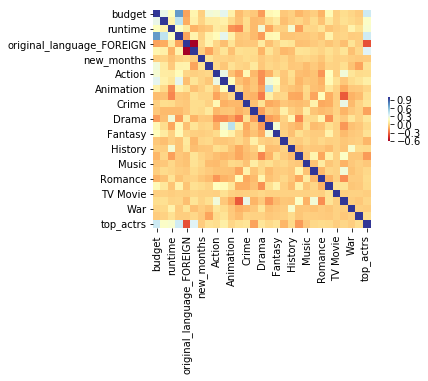

In [145]:
corr = train.corr()
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdYlBu", vmax=1, vmin=-0.6, center=0.2, square=True, linewidths=0, cbar_kws={"shrink": .2})

In [146]:
train.apply(lambda x: abs(x.corr(train['revenue'])))

budget                       0.730444
popularity                   0.461078
runtime                      0.216691
revenue                      1.000000
original_language_FOREIGN    0.141707
original_language_en         0.141707
new_months                   0.000720
decades                      0.132715
Action                       0.184065
Adventure                    0.328130
Animation                    0.130622
Comedy                       0.031550
Crime                        0.023139
Documentary                  0.078247
Drama                        0.159657
Family                       0.161394
Fantasy                      0.170780
Foreign                      0.048318
History                      0.044425
Horror                       0.034427
Music                        0.032431
Mystery                      0.015009
Romance                      0.050004
Science Fiction              0.132054
TV Movie                     0.003305
Thriller                     0.006335
War         

The most correlated features to revenue according to the above matrix are : **Budget(0.73), Popularity(0.46),Run time(0.21), Adventure(0.32) and Top Actors(0.4).**

In [147]:
# Save these columns for later
top_cols = ['budget','popularity','runtime','Adventure','top_actrs']

Lets see how movie budgets have changed through the decades:

In [148]:
#use the train_budget_dict data for graph
budgets = []
decades = [20,30,40,50,60,70,80,90,100,110]
for decade in decades:
    budgets.append(train_budget_dict[decade])

In [149]:
budgets

[288180.4,
 769465.5,
 1138492.09,
 2247582.95,
 5512374.43,
 4585680.9,
 7872790.78,
 21798811.37,
 29281170.09,
 27277969.07]

In [150]:
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

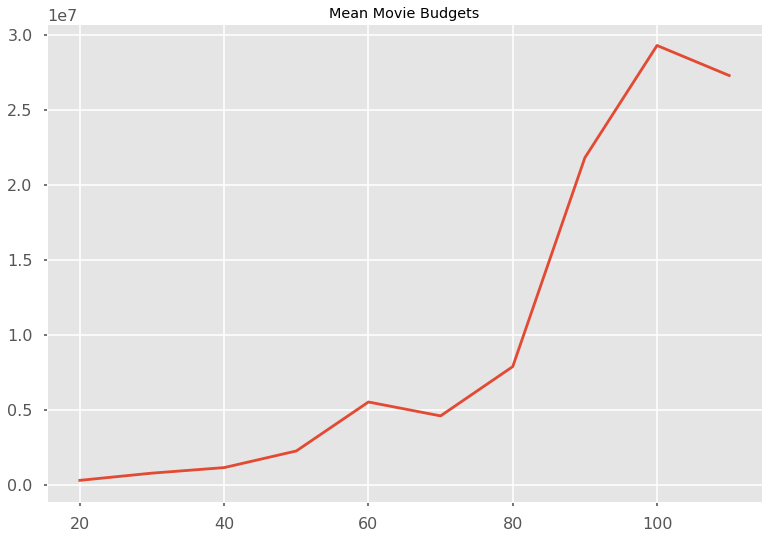

In [151]:
plt.plot(decades,budgets)
plt.title('Mean Movie Budgets')
plt.show()

And finally, lets plot a histogram of the number of A-list celebrities in a movie:

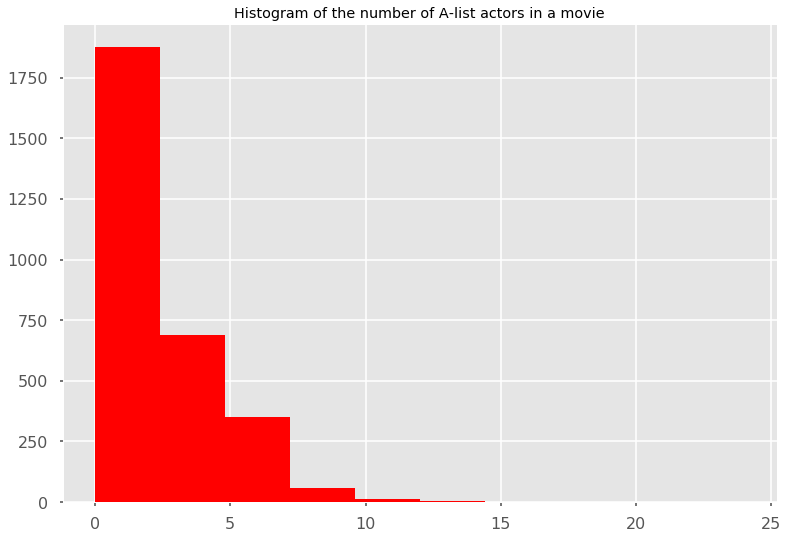

In [152]:
fig, ax = plt.subplots()
ax.hist(train.top_actrs, color = 'red')
ax.set_title('Histogram of the number of A-list actors in a movie')
plt.show()

# 5. Pre-Modeling Data Prep
## 5.1 Combine data and Treat skews in features and target
We need to first combine all our data, treat them a little more then we can start modelling

In [153]:
train.columns

Index(['budget', 'popularity', 'runtime', 'revenue',
       'original_language_FOREIGN', 'original_language_en', 'new_months',
       'decades', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'top_actrs'],
      dtype='object')

In [154]:
cols = ['budget', 'popularity', 'runtime',
       'original_language_FOREIGN', 'original_language_en', 'new_months',
       'decades', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'top_actrs']

In [155]:
#combine all data, start by copying train df
train_copy = train.loc[:,cols]

In [156]:
#save test index for later
test_index = len(test.index)

In [157]:
test_index

4398

In [158]:
#make all data df
all_data = train_copy
all_data = all_data.append(test, ignore_index = True,sort=False)

In [159]:
print(all_data.shape[0])
print(test.shape[0] + train.shape[0])

7391
7391


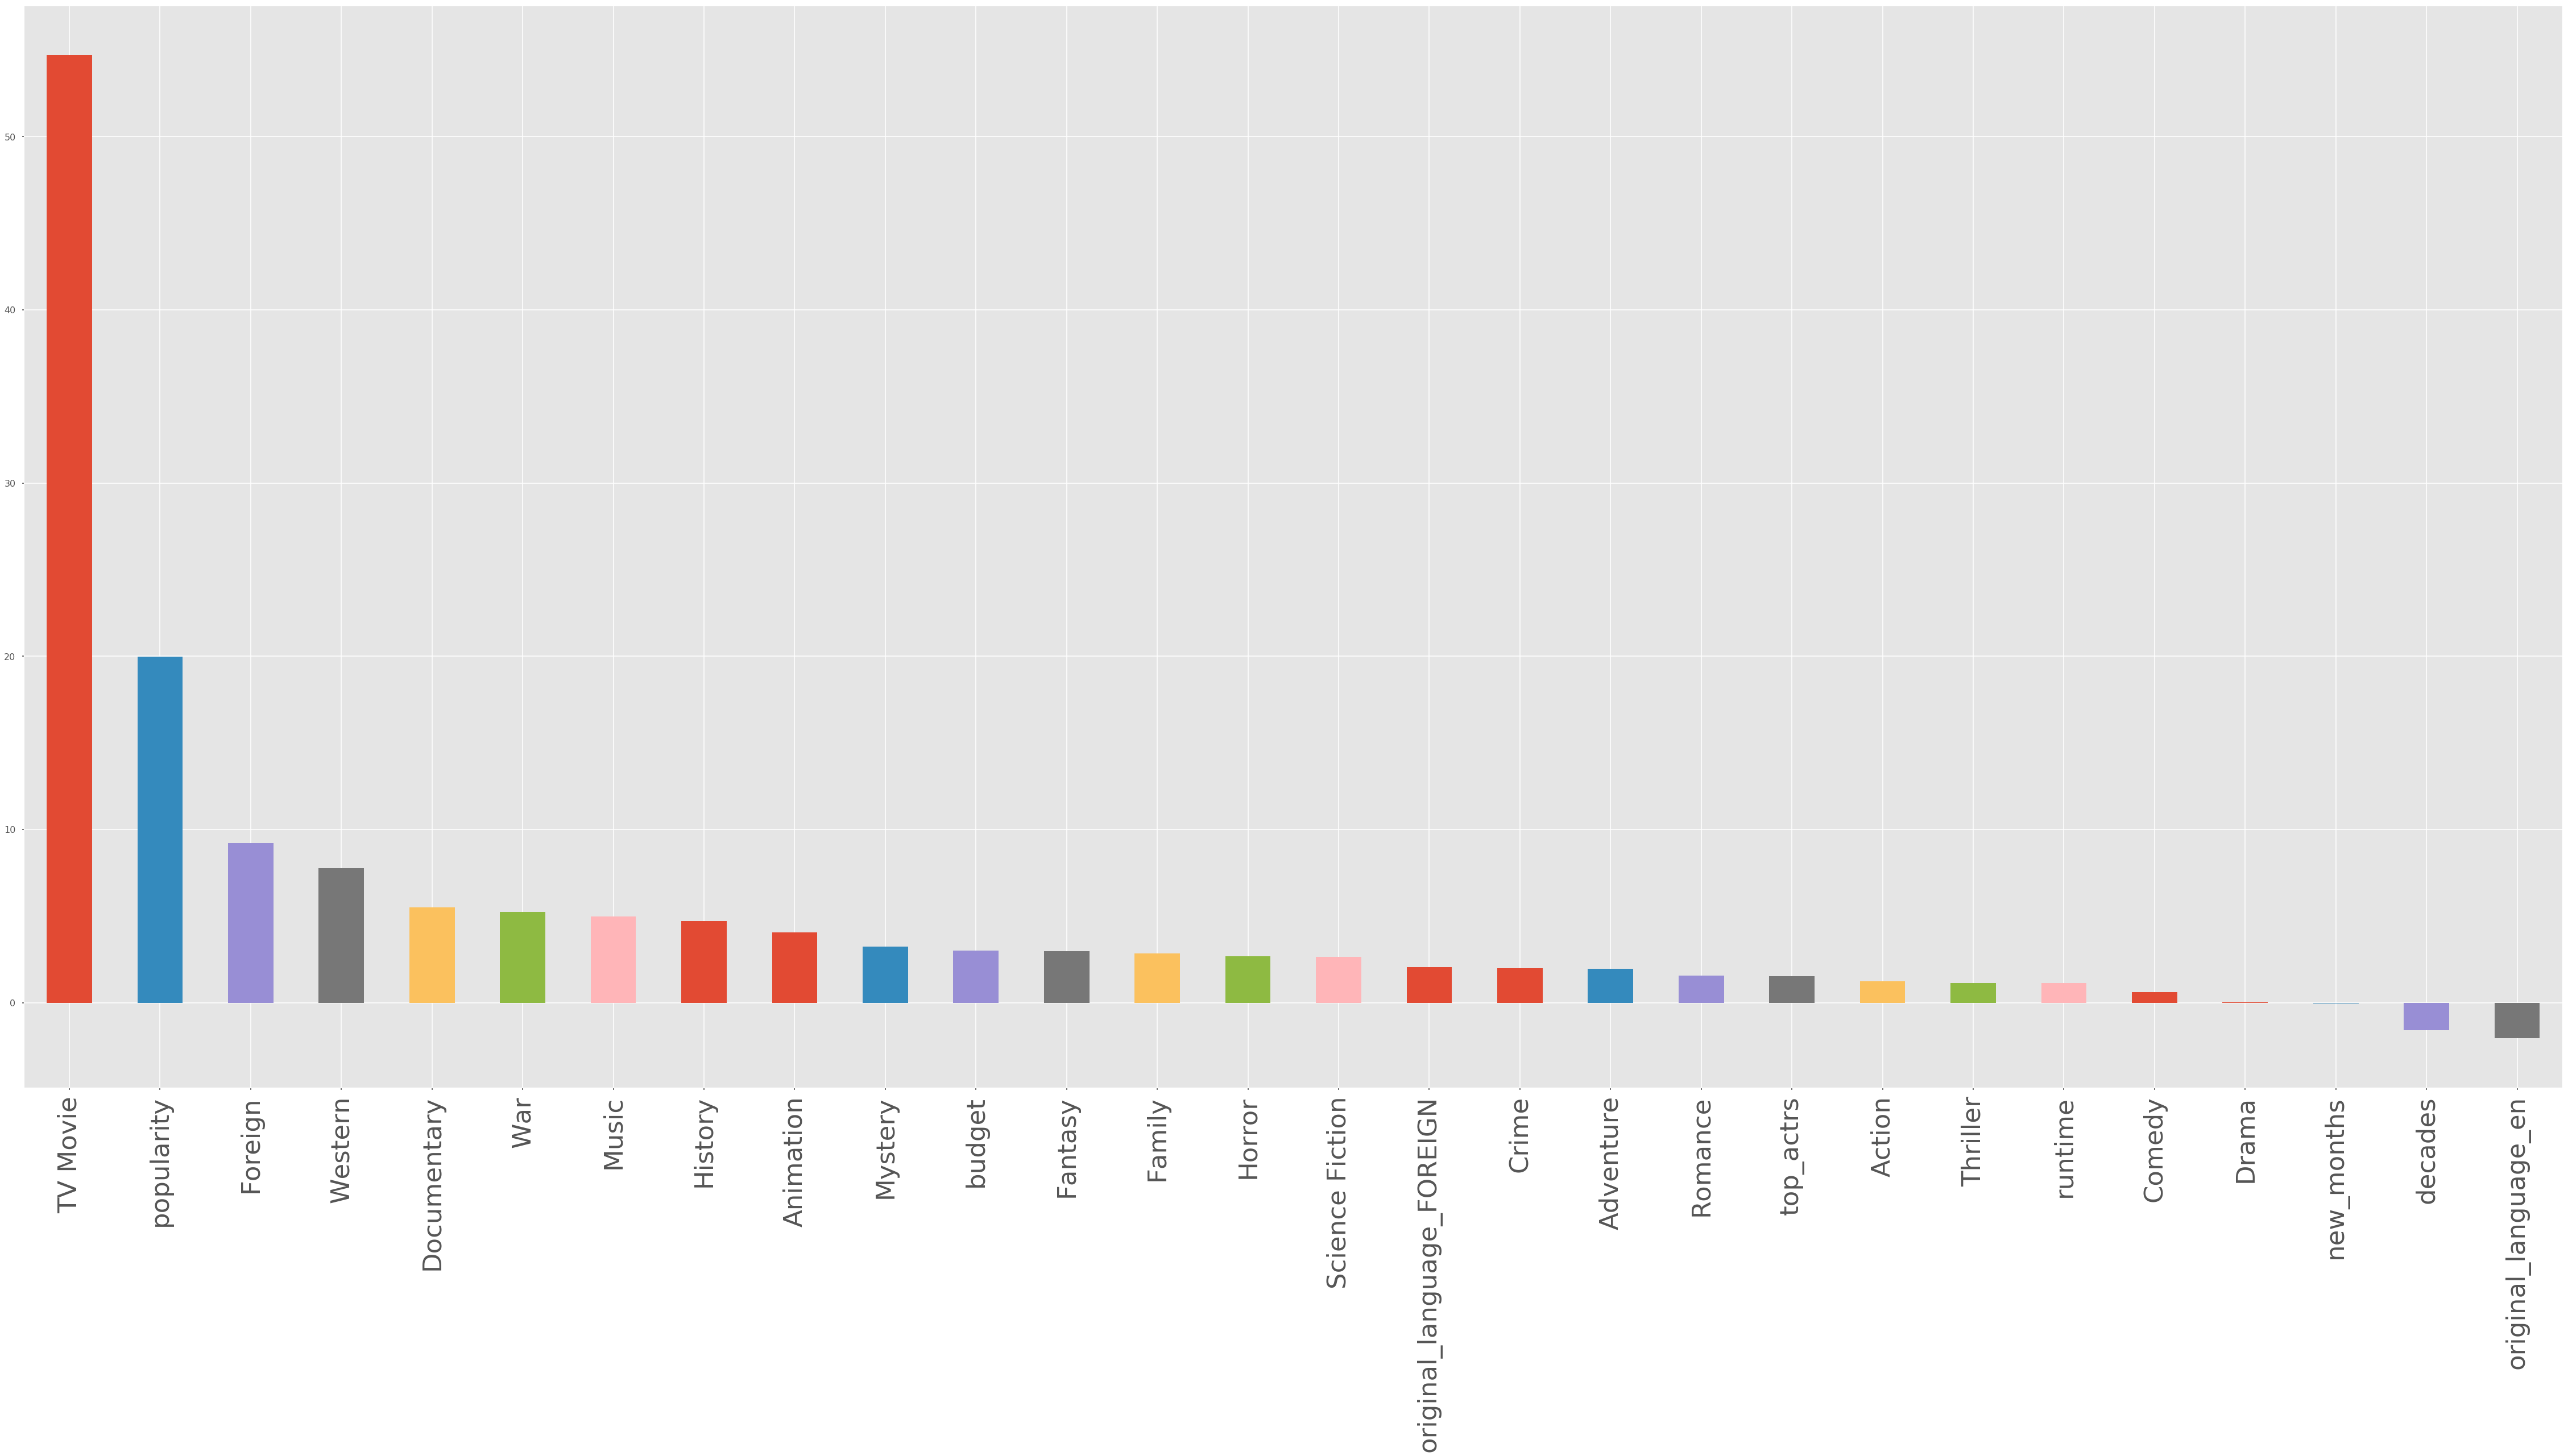

In [160]:
#show all skews 
plt.subplots(figsize =(80, 35))
plt.xticks(fontsize=45)
all_data.skew().sort_values(ascending=False).plot(kind='bar')

Transform the features with abs skew values > 0.5 to follow more closely the normal distribution. Use Box-Cox.

In [161]:
skewed_feats = all_data.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = skewed_feats[abs(skewed_feats) > 0.5]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print(skewness.shape[0],  "skewed numerical features have been Box-Cox transformed")

26 skewed numerical features have been Box-Cox transformed


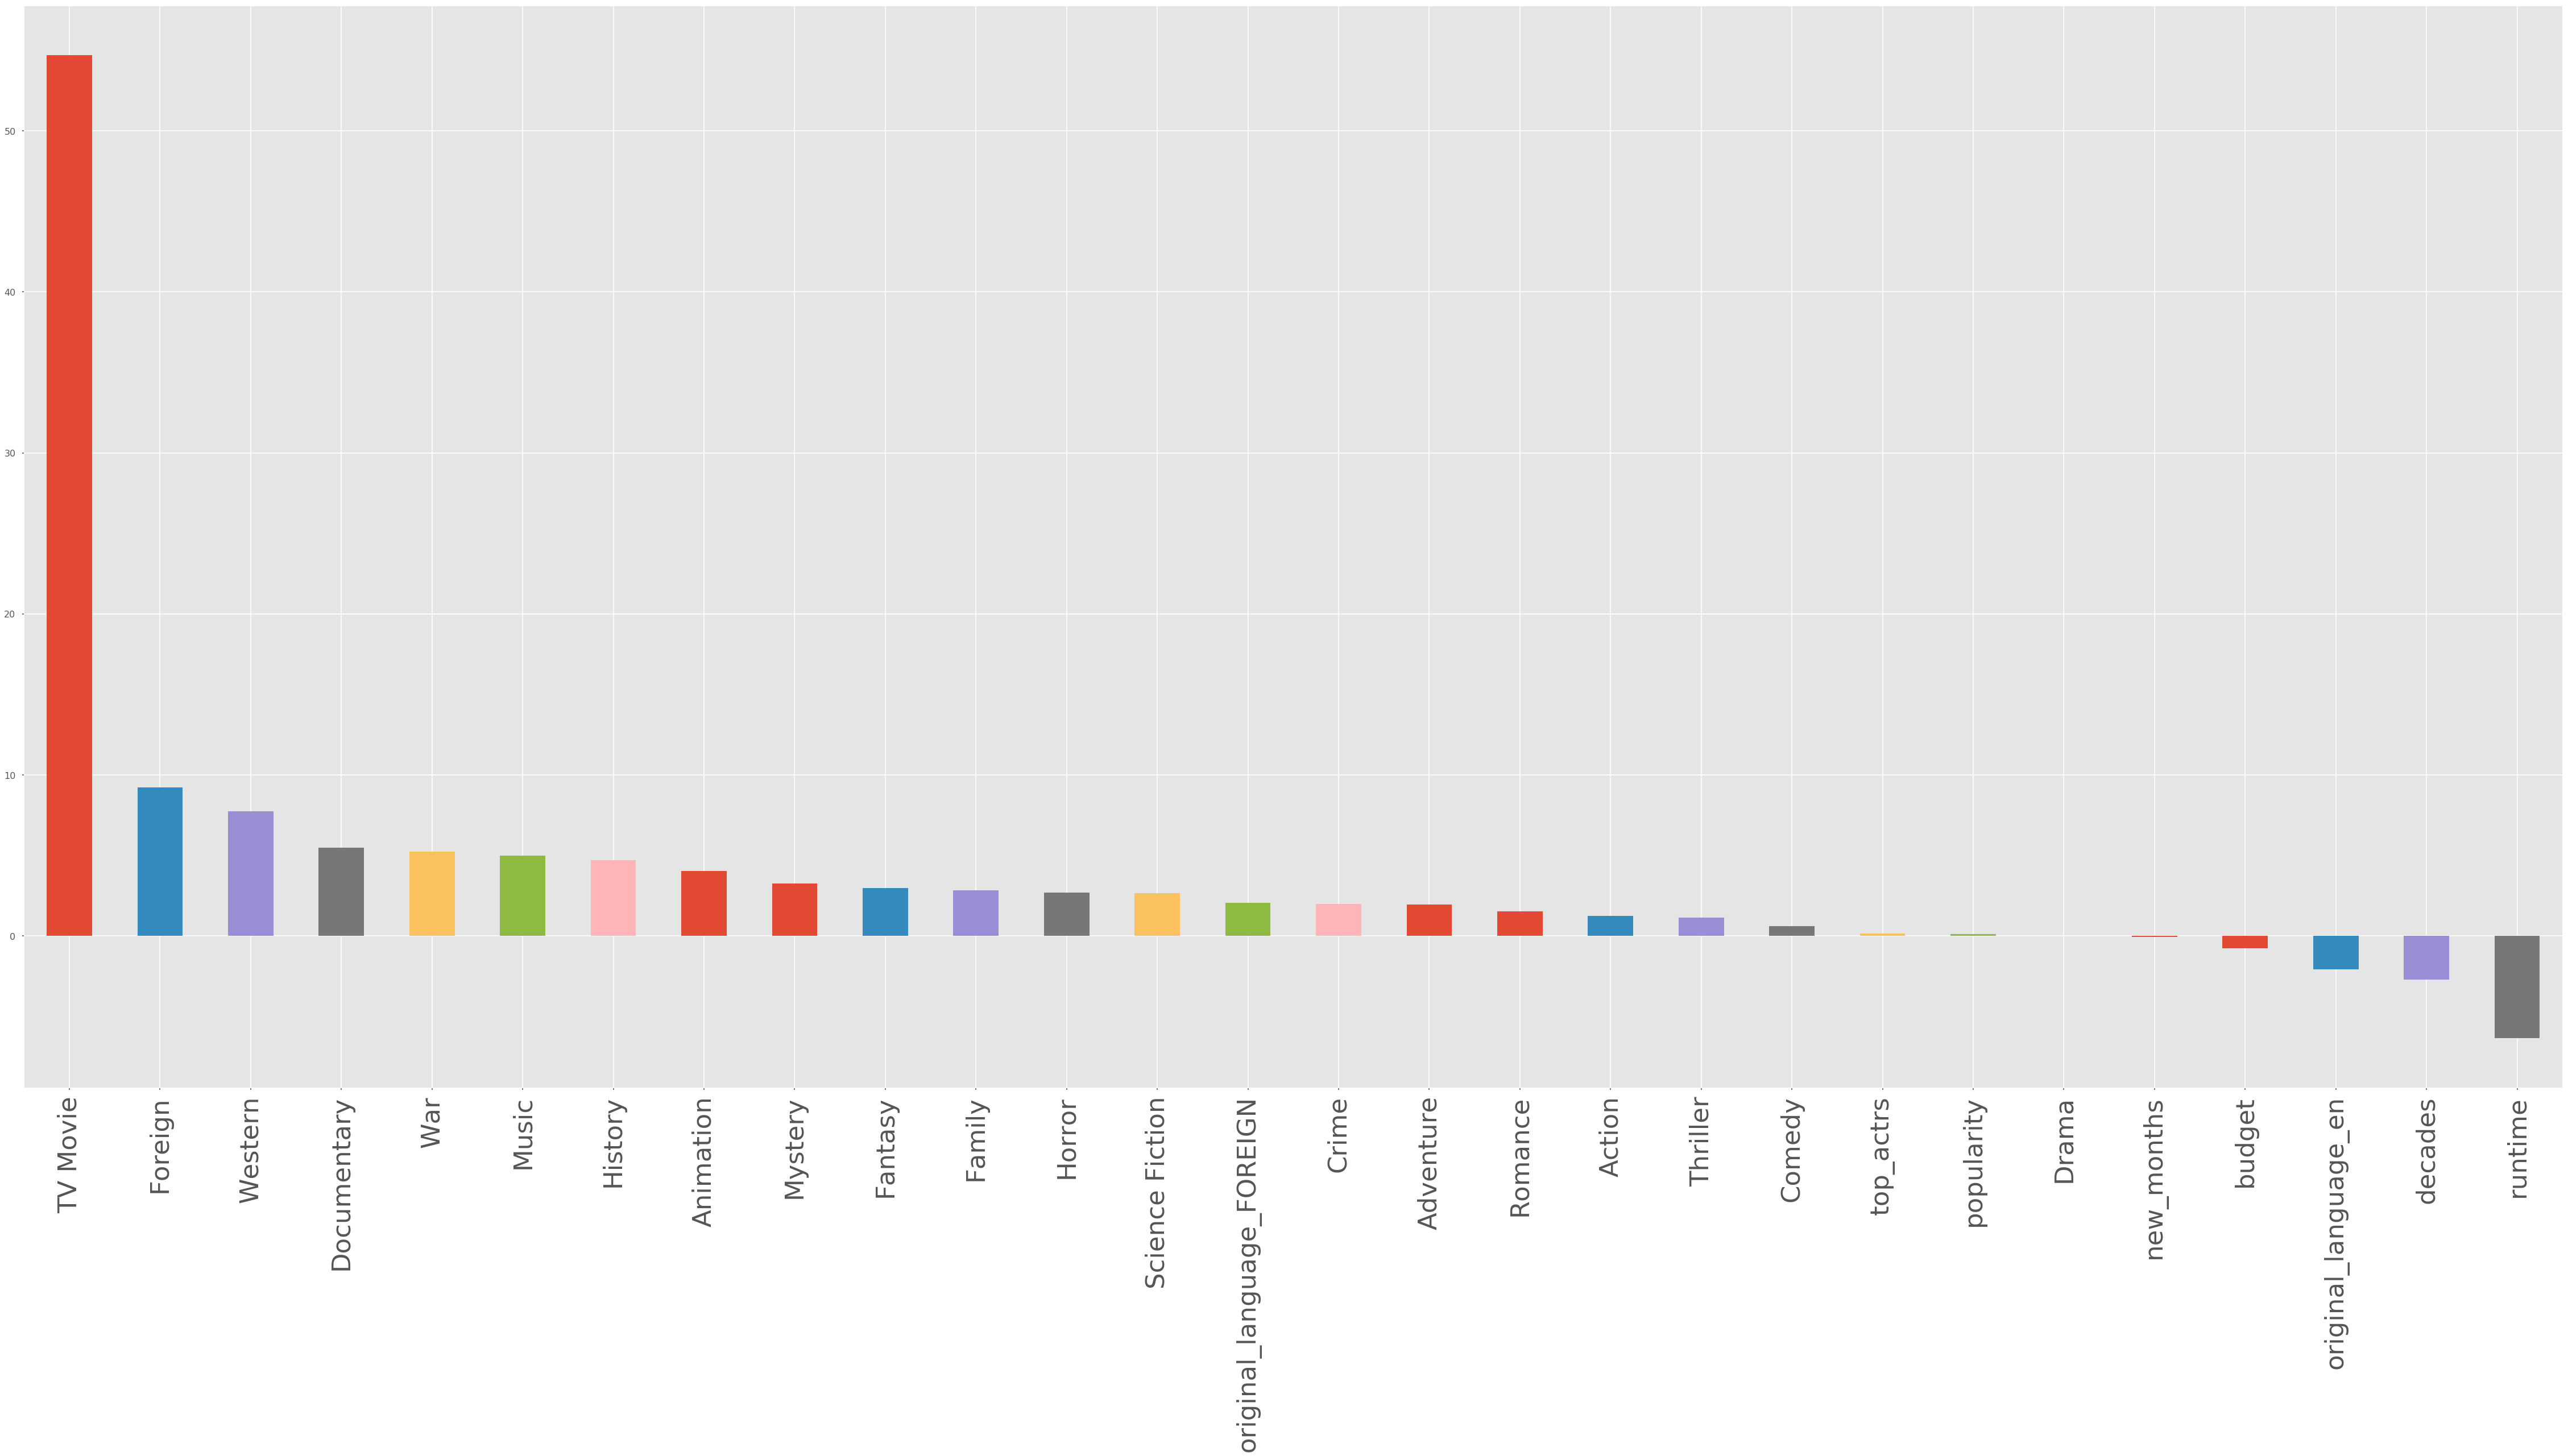

In [162]:
#show all skews again
plt.subplots(figsize =(80, 35))
plt.xticks(fontsize=45)
all_data.skew().sort_values(ascending=False).plot(kind='bar')

In [163]:
#save target
y_train = train['revenue']

In [164]:
#treat skew in target if abs(skew) is greater than 0.5
#abs(y_train.skew())

In [165]:
#Check the distribution visually 
#plt.subplots(figsize=(15, 10))
#g = sns.distplot(y_train, fit=norm, label = "Skewness : %.2f"%(y_train.skew()))

In [166]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
#y_train = np.log1p(y_train)

/home/harry/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


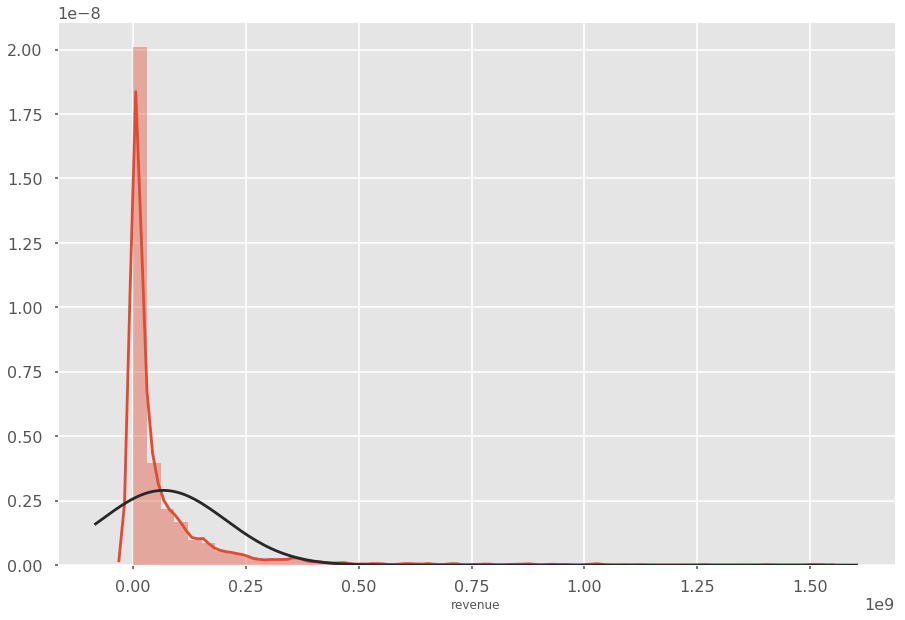

In [167]:
#Check the new distribution 
plt.subplots(figsize=(15, 10))
g = sns.distplot(y_train, fit=norm, label = "Skewness : %.2f"%(y_train.skew()))

In [168]:
abs(y_train.skew())

4.537523878735987

## 5.2 Drop columns with low variance (bottom 10%)

In [169]:
#reject column if variance is in bottom 10%
index = range(0,(len(all_data.columns)))
columns = ['ColumnName','Var']
#var_data = {'Column':[np.array(all_data.columns)],'Var':[np.array(all_data.var())]}
var_cols = pd.DataFrame(index=index,columns=columns)
var_cols['Var'] = list(all_data.var())
var_cols['ColumnName'] = all_data.columns
prcntl = np.percentile(var_cols['Var'], 10)

In [170]:
low_var_cols = list()
#construct a list for low variance columns only
for indx in range(0,(len(var_cols))):
    if var_cols.loc[indx,'Var'] < prcntl:
        low_var_cols.append(var_cols.loc[indx,'ColumnName'])
low_var_cols

['Foreign', 'TV Movie', 'Western']

In [171]:
#now drop the low var columns
all_data = all_data.drop(labels = low_var_cols, axis= 1)

In [172]:
all_data.head()

,budget,popularity,runtime,original_language_FOREIGN,original_language_en,new_months,decades,Action,Adventure,Animation,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,top_actrs
0,72.006739,2.366073,6.512196,0.000000,0.730463,5,6.844946,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.194318
1,85.424450,2.640601,6.899104,0.000000,0.730463,11,6.654950,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.730463,0.0,0.000000,0.0,2.055642
2,56.674470,5.811354,6.751853,0.000000,0.730463,1,6.844946,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.194318
3,47.756772,1.593831,7.054610,0.730463,0.000000,6,6.844946,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.730463,0.0,0.000000
4,81.214741,0.810137,6.986732,0.730463,0.000000,5,6.654950,0.730463,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.730463,0.0,0.000000


## 5.3 Normalize all data 

In [173]:
data_norm = (all_data - all_data.mean()) / (all_data.max() - all_data.min())

In [174]:
data_norm.head()

,budget,popularity,runtime,original_language_FOREIGN,original_language_en,new_months,decades,Action,Adventure,Animation,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,top_actrs
0,-0.013114,0.000114,-0.026727,-0.141253,0.141253,-0.154918,0.105474,-0.235286,-0.151265,-0.051684,...,-0.084968,-0.039913,-0.099445,-0.036125,-0.074415,-0.194155,-0.100663,-0.25301,-0.032878,0.034102
1,0.097150,0.026250,0.014839,-0.141253,0.141253,0.390536,0.041849,-0.235286,-0.151265,-0.051684,...,-0.084968,-0.039913,-0.099445,-0.036125,-0.074415,0.805845,-0.100663,-0.25301,-0.032878,0.242266
2,-0.139110,0.328115,-0.000980,-0.141253,0.141253,-0.518555,0.105474,-0.235286,-0.151265,-0.051684,...,-0.084968,-0.039913,-0.099445,-0.036125,-0.074415,-0.194155,-0.100663,-0.25301,-0.032878,0.034102
3,-0.212393,-0.073406,0.031546,0.858747,-0.858747,-0.064009,0.105474,-0.235286,-0.151265,-0.051684,...,-0.084968,-0.039913,-0.099445,-0.036125,-0.074415,-0.194155,-0.100663,0.74699,-0.032878,-0.254541
4,0.062555,-0.148016,0.024254,0.858747,-0.858747,-0.154918,0.041849,0.764714,-0.151265,-0.051684,...,-0.084968,-0.039913,-0.099445,-0.036125,-0.074415,-0.194155,-0.100663,0.74699,-0.032878,-0.254541


In [175]:
data_norm.tail()

,budget,popularity,runtime,original_language_FOREIGN,original_language_en,new_months,decades,Action,Adventure,Animation,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,top_actrs
7386,0.102708,0.049230,0.024254,-0.141253,0.141253,0.390536,0.041849,-0.235286,-0.151265,-0.051684,...,-0.084968,-0.039913,-0.099445,-0.036125,-0.074415,-0.194155,-0.100663,0.74699,-0.032878,0.034102
7387,0.017190,-0.009171,-0.022248,-0.141253,0.141253,0.390536,0.041849,0.764714,0.848735,-0.051684,...,-0.084968,-0.039913,-0.099445,-0.036125,-0.074415,-0.194155,-0.100663,0.74699,-0.032878,0.034102
7388,-0.000034,0.044519,0.043835,-0.141253,0.141253,-0.336736,-0.103401,-0.235286,-0.151265,-0.051684,...,-0.084968,-0.039913,-0.099445,-0.036125,-0.074415,-0.194155,-0.100663,-0.25301,-0.032878,0.185397
7389,-0.176777,0.144780,-0.011390,-0.141253,0.141253,-0.154918,0.105474,-0.235286,-0.151265,-0.051684,...,-0.084968,-0.039913,0.900555,-0.036125,-0.074415,-0.194155,-0.100663,0.74699,-0.032878,-0.254541
7390,-0.371501,0.065031,-0.045491,0.858747,-0.858747,0.481445,-0.283134,-0.235286,-0.151265,-0.051684,...,-0.084968,-0.039913,-0.099445,-0.036125,-0.074415,-0.194155,-0.100663,-0.25301,-0.032878,-0.254541


Now we can recreate our test and train datasets for stacking and start modelling

In [176]:
norm_test = data_norm[:test_index]
norm_train = data_norm[test_index:]

In [177]:
norm_train.shape

(2993, 25)

In [178]:
norm_test.shape

(4398, 25)

In [179]:
train_copy.shape

(2993, 28)

In [180]:
test.shape

(4398, 27)

In [181]:
# Sample training data again for stacking
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(norm_train, y_train, test_size=0.3, random_state=42)
print('X_train: ', X_train.shape, '\nX_test: ', X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train:  (2095, 25) 
X_test:  (898, 25) 
Y_train:  (2095,) 
Y_test:  (898,)


# 6. Modeling
Lets try a few models with hyper parameter opt. and see what the RMSEs are. I am only using features with the highest correlation indices for some of the models

In [197]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), RandomForestRegressor(), xgb.XGBRegressor()]
KR_param_grid = {'alpha': [10], 'coef0': [100], 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}
EN_param_grid = {'alpha': [1,10], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], 'normalize': [False], 
                         'precompute': [False], 'max_iter': [300], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
LASS_param_grid = {'alpha': [0.5, 1, 10], 'copy_X': [True], 'fit_intercept': [True], 'normalize': [False], 'precompute': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}
GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
                                        'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
#BR_param_grid = {'n_iter': [500]}
#LL_param_grid = {'criterion': ['aic'], 'normalize': [True], 'max_iter': [1000], 'copy_X': [True], 'precompute': ['auto'], 'eps': [0.000001]}
RFR_param_grid = {'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]}
XGB_param_grid = {'max_depth': [3], 'learning_rate': [0.1], 'n_estimators': [300], 'booster': ['gbtree'], 'gamma': [0], 'reg_alpha': [0.1],
                  'reg_lambda': [0.7], 'max_delta_step': [0], 'min_child_weight': [1], 'colsample_bytree': [0.5], 'colsample_bylevel': [0.2],
                  'scale_pos_weight': [1]}
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
after_model_compare = pd.DataFrame(columns = columns)
shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

row_index = 0
for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)

    #set name and parameters
    model_name = alg.__class__.__name__
    after_model_compare.loc[row_index, 'Name'] = model_name
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    after_model_compare.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    after_training_results = np.sqrt(-gs_alg.best_score_)
    after_test_results = np.sqrt(((Y_test-gs_alg.predict(X_test))**2).mean())
    
    after_model_compare.loc[row_index, 'Train Accuracy Mean'] = (after_training_results)*100
    after_model_compare.loc[row_index, 'Test Accuracy'] = (after_test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'Optimised...')

decimals = 3
after_model_compare['Train Accuracy Mean'] = after_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, 1))
after_model_compare['Test Accuracy'] = after_model_compare['Test Accuracy'].apply(lambda x: round(x, 1))
after_model_compare

1 KernelRidge Optimised...
2 ElasticNet Optimised...
3 Lasso Optimised...
4 GradientBoostingRegressor Optimised...
5 BayesianRidge Optimised...


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/harry/anaconda3/lib/python3.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/harry/anaconda3/lib/python3.7/runpy.py in _run_code(code=<code object <module> at 0x7ffa020fd030, file "/...3.7/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/harry/anaconda3/lib/python3.7/site-packages/__pycache__/ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/harry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/harry/.../python3.7/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7ffa020fd030, file "/...3.7/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/harry/anaconda3/lib/python3.7/site-packages/__pycache__/ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/harry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/harry/.../python3.7/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    492         if self.poller is not None:
    493             self.poller.start()
    494         self.kernel.start()
    495         self.io_loop = ioloop.IOLoop.current()
    496         try:
--> 497             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    498         except KeyboardInterrupt:
    499             pass
    500 
    501 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
/home/harry/anaconda3/lib/python3.7/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    518         sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    519                                finalizer=self._asyncgen_finalizer_hook)
    520         try:
    521             events._set_running_loop(self)
    522             while True:
--> 523                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    524                 if self._stopping:
    525                     break
    526         finally:
    527             self._stopping = False

...........................................................................
/home/harry/anaconda3/lib/python3.7/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1753                         logger.warning('Executing %s took %.3f seconds',
   1754                                        _format_handle(handle), dt)
   1755                 finally:
   1756                     self._current_handle = None
   1757             else:
-> 1758                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(11, 1)>>
   1759         handle = None  # Needed to break cycles when an exception occurs.
   1760 
   1761     def _set_coroutine_origin_tracking(self, enabled):
   1762         if bool(enabled) == bool(self._coroutine_origin_tracking_enabled):

...........................................................................
/home/harry/anaconda3/lib/python3.7/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(11, 1)>)
     83     def cancelled(self):
     84         return self._cancelled
     85 
     86     def _run(self):
     87         try:
---> 88             self._context.run(self._callback, *self._args)
        self._context.run = <built-in method run of Context object>
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (11, 1)
     89         except Exception as exc:
     90             cb = format_helpers._format_callback_source(
     91                 self._callback, self._args)
     92             msg = f'Exception in callback {cb}'

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=11, events=1)
    117             self.writers.remove(fd)
    118         del self.handlers[fd]
    119 
    120     def _handle_events(self, fd, events):
    121         fileobj, handler_func = self.handlers[fd]
--> 122         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    123 
    124     def start(self):
    125         try:
    126             old_loop = asyncio.get_event_loop()

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'models = [KernelRidge(), ElasticNet(), Lasso(), ....apply(lambda x: round(x, 1))\nafter_model_compare', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 5, 1, 13, 11, 0, 588413, tzinfo=tzutc()), 'msg_id': 'a0c06237bea4480da45a169d915a0d80', 'msg_type': 'execute_request', 'session': '7a556ac5721e4c26842cbc36e78d5c2e', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'a0c06237bea4480da45a169d915a0d80', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warning("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'7a556ac5721e4c26842cbc36e78d5c2e']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'models = [KernelRidge(), ElasticNet(), Lasso(), ....apply(lambda x: round(x, 1))\nafter_model_compare', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 5, 1, 13, 11, 0, 588413, tzinfo=tzutc()), 'msg_id': 'a0c06237bea4480da45a169d915a0d80', 'msg_type': 'execute_request', 'session': '7a556ac5721e4c26842cbc36e78d5c2e', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'a0c06237bea4480da45a169d915a0d80', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'7a556ac5721e4c26842cbc36e78d5c2e'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'models = [KernelRidge(), ElasticNet(), Lasso(), ....apply(lambda x: round(x, 1))\nafter_model_compare', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 5, 1, 13, 11, 0, 588413, tzinfo=tzutc()), 'msg_id': 'a0c06237bea4480da45a169d915a0d80', 'msg_type': 'execute_request', 'session': '7a556ac5721e4c26842cbc36e78d5c2e', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'a0c06237bea4480da45a169d915a0d80', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='models = [KernelRidge(), ElasticNet(), Lasso(), ....apply(lambda x: round(x, 1))\nafter_model_compare', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'models = [KernelRidge(), ElasticNet(), Lasso(), ....apply(lambda x: round(x, 1))\nafter_model_compare'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('models = [KernelRidge(), ElasticNet(), Lasso(), ....apply(lambda x: round(x, 1))\nafter_model_compare',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('models = [KernelRidge(), ElasticNet(), Lasso(), ....apply(lambda x: round(x, 1))\nafter_model_compare',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='models = [KernelRidge(), ElasticNet(), Lasso(), ....apply(lambda x: round(x, 1))\nafter_model_compare', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'models = [KernelRidge(), ElasticNet(), Lasso(), ....apply(lambda x: round(x, 1))\nafter_model_compare'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='models = [KernelRidge(), ElasticNet(), Lasso(), ....apply(lambda x: round(x, 1))\nafter_model_compare', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.For object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-197-ef297ff9e2a9>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7ff9b9becb70, executi...rue silent=False shell_futures=True> result=None>)
   2896             raise ValueError("Interactivity was %r" % interactivity)
   2897         try:
   2898             for i, node in enumerate(to_run_exec):
   2899                 mod = ast.Module([node])
   2900                 code = compiler(mod, cell_name, "exec")
-> 2901                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7ff9b7f48f60, file "<ipython-input-197-ef297ff9e2a9>", line 21>
        result = <ExecutionResult object at 7ff9b9becb70, executi...rue silent=False shell_futures=True> result=None>
   2902                     return True
   2903 
   2904             for i, node in enumerate(to_run_interactive):
   2905                 mod = ast.Interactive([node])

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7ff9b7f48f60, file "<ipython-input-197-ef297ff9e2a9>", line 21>, result=<ExecutionResult object at 7ff9b9becb70, executi...rue silent=False shell_futures=True> result=None>)
   2956         outflag = True  # happens in more places, so it's easier as default
   2957         try:
   2958             try:
   2959                 self.hooks.pre_run_code_hook()
   2960                 #rprint('Running code', repr(code_obj)) # dbg
-> 2961                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7ff9b7f48f60, file "<ipython-input-197-ef297ff9e2a9>", line 21>
        self.user_global_ns = {'BR_param_grid': {'n_iter': [500]}, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'EN_param_grid': {'alpha': [1, 10], 'copy_X': [True], 'fit_intercept': [True], 'l1_ratio': [0.6], 'max_iter': [300], 'normalize': [False], 'precompute': [False], 'random_state': [None], 'selection': ['random'], 'tol': [0.001]}, 'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'ExtraTreesRegressor': <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, 'GB_param_grid': {'learning_rate': [0.1], 'loss': ['huber'], 'max_depth': [3], 'min_samples_leaf': [5], 'min_samples_split': [0.0025], 'n_estimators': [300]}, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nfrom nump...ipy.special import boxcox1p\nimport xgboost as xgb', "train = pd.read_csv('train.csv')\ntest = pd.read_csv('test.csv')", 'train.shape', 'test.shape', '#Save ID for submission\ntest_ID = test.id', 'train.head()', "drop_cols = ['belongs_to_collection','homepage',...anies','production_countries','spoken_languages']", 'for col in drop_cols:\n    train.drop(col, axis=1... True)\n    test.drop(col, axis=1, inplace = True)', 'train.shape', 'test.shape', 'train.isnull().sum()', 'test.isnull().sum()', "#function that cleans up the genre data; essenti...  clean_list.append('NULL')\n    return clean_list", 'clean_genrelist = clean_genre(train)', 'train.genres = clean_genrelist', 'train.genres.head(5)', 'clean_genrelist = clean_genre(test)', 'test.genres = clean_genrelist', 'test.genres.head(5)', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, ...}
        self.user_ns = {'BR_param_grid': {'n_iter': [500]}, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'EN_param_grid': {'alpha': [1, 10], 'copy_X': [True], 'fit_intercept': [True], 'l1_ratio': [0.6], 'max_iter': [300], 'normalize': [False], 'precompute': [False], 'random_state': [None], 'selection': ['random'], 'tol': [0.001]}, 'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'ExtraTreesRegressor': <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, 'GB_param_grid': {'learning_rate': [0.1], 'loss': ['huber'], 'max_depth': [3], 'min_samples_leaf': [5], 'min_samples_split': [0.0025], 'n_estimators': [300]}, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nfrom nump...ipy.special import boxcox1p\nimport xgboost as xgb', "train = pd.read_csv('train.csv')\ntest = pd.read_csv('test.csv')", 'train.shape', 'test.shape', '#Save ID for submission\ntest_ID = test.id', 'train.head()', "drop_cols = ['belongs_to_collection','homepage',...anies','production_countries','spoken_languages']", 'for col in drop_cols:\n    train.drop(col, axis=1... True)\n    test.drop(col, axis=1, inplace = True)', 'train.shape', 'test.shape', 'train.isnull().sum()', 'test.isnull().sum()', "#function that cleans up the genre data; essenti...  clean_list.append('NULL')\n    return clean_list", 'clean_genrelist = clean_genre(train)', 'train.genres = clean_genrelist', 'train.genres.head(5)', 'clean_genrelist = clean_genre(test)', 'test.genres = clean_genrelist', 'test.genres.head(5)', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, ...}
   2962             finally:
   2963                 # Reset our crash handler in place
   2964                 sys.excepthook = old_excepthook
   2965         except SystemExit as e:

...........................................................................
/home/harry/TMDB-Box-Office-Prediction/<ipython-input-197-ef297ff9e2a9> in <module>()
     25 
     26     #set name and parameters
     27     model_name = alg.__class__.__name__
     28     after_model_compare.loc[row_index, 'Name'] = model_name
     29     
---> 30     gs_alg.fit(X_train, Y_train)
     31     gs_best = gs_alg.best_estimator_
     32     after_model_compare.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
     33     
     34     #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=ShuffleSplit(n_splits=5, random_...     scoring='neg_mean_squared_error', verbose=0), X=        budget  popularity   runtime  original_l... -0.032878  -0.078003  

[2095 rows x 25 columns], y=1269      4371000
2495      3200000
2115    2422...7542952
Name: revenue, Length: 2095, dtype: int64, groups=None, **fit_params={})
    635                                   return_train_score=self.return_train_score,
    636                                   return_n_test_samples=True,
    637                                   return_times=True, return_parameters=False,
    638                                   error_score=self.error_score)
    639           for parameters, (train, test) in product(candidate_params,
--> 640                                                    cv.split(X, y, groups)))
        cv.split = <bound method BaseShuffleSplit.split of ShuffleS...random_state=42, test_size=0.2, train_size=None)>
        X =         budget  popularity   runtime  original_l... -0.032878  -0.078003  

[2095 rows x 25 columns]
        y = 1269      4371000
2495      3200000
2115    2422...7542952
Name: revenue, Length: 2095, dtype: int64
        groups = None
    641 
    642         # if one choose to see train score, "out" will contain train score info
    643         if self.return_train_score:
    644             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed May  1 23:11:16 2019
PID: 17110                   Python 3.7.0: /home/harry/anaconda3/bin/python
...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False),         budget  popularity   runtime  original_l... -0.032878  -0.078003  

[2095 rows x 25 columns], 1269      4371000
2495      3200000
2115    2422...7542952
Name: revenue, Length: 2095, dtype: int64, {'score': make_scorer(mean_squared_error, greater_is_better=False)}, array([  30, 1178, 1628, ..., 1130, 1294,  860]), array([ 210, 1169, 1146,  879,   29,  485, 1102,...1352, 1053, 1941, 1337, 2083,  393,
       1554]), 0, {'copy_X': True, 'criterion': 'aic', 'eps': 1e-06, 'max_iter': 1000, 'normalize': True, 'precompute': 'auto'}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False),         budget  popularity   runtime  original_l... -0.032878  -0.078003  

[2095 rows x 25 columns], 1269      4371000
2495      3200000
2115    2422...7542952
Name: revenue, Length: 2095, dtype: int64, {'score': make_scorer(mean_squared_error, greater_is_better=False)}, array([  30, 1178, 1628, ..., 1130, 1294,  860]), array([ 210, 1169, 1146,  879,   29,  485, 1102,...1352, 1053, 1941, 1337, 2083,  393,
       1554]), 0, {'copy_X': True, 'criterion': 'aic', 'eps': 1e-06, 'max_iter': 1000, 'normalize': True, 'precompute': 'auto'})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), X=        budget  popularity   runtime  original_l... -0.032878  -0.078003  

[2095 rows x 25 columns], y=1269      4371000
2495      3200000
2115    2422...7542952
Name: revenue, Length: 2095, dtype: int64, scorer={'score': make_scorer(mean_squared_error, greater_is_better=False)}, train=array([  30, 1178, 1628, ..., 1130, 1294,  860]), test=array([ 210, 1169, 1146,  879,   29,  485, 1102,...1352, 1053, 1941, 1337, 2083,  393,
       1554]), verbose=0, parameters={'copy_X': True, 'criterion': 'aic', 'eps': 1e-06, 'max_iter': 1000, 'normalize': True, 'precompute': 'auto'}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    439                       for k, v in fit_params.items()])
    440 
    441     test_scores = {}
    442     train_scores = {}
    443     if parameters is not None:
--> 444         estimator.set_params(**parameters)
        estimator.set_params = <bound method BaseEstimator.set_params of Random... random_state=None, verbose=0, warm_start=False)>
        parameters = {'copy_X': True, 'criterion': 'aic', 'eps': 1e-06, 'max_iter': 1000, 'normalize': True, 'precompute': 'auto'}
    445 
    446     start_time = time.time()
    447 
    448     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/base.py in set_params(self=RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), **params={'copy_X': True, 'criterion': 'aic', 'eps': 1e-06, 'max_iter': 1000, 'normalize': True, 'precompute': 'auto'})
    269             key, delim, sub_key = key.partition('__')
    270             if key not in valid_params:
    271                 raise ValueError('Invalid parameter %s for estimator %s. '
    272                                  'Check the list of available parameters '
    273                                  'with `estimator.get_params().keys()`.' %
--> 274                                  (key, self))
        key = 'copy_X'
        self = RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False)
    275 
    276             if delim:
    277                 nested_params[key][sub_key] = value
    278             else:

ValueError: Invalid parameter copy_X for estimator RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________

# 7. Stacking

In [188]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
stacked_validation_train = pd.DataFrame()
stacked_test_train = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    stacked_validation_train.insert(loc = row_index, column = names[0], value = gs_best.predict(X_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking validation dataset...')
    
    stacked_test_train.insert(loc = row_index, column = names[0], value = gs_best.predict(norm_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking test dataset...')
    print("-"*50)
    names.pop(0)
    
    row_index+=1
    
print('Done')

1 KernelRidge predictions added to stacking validation dataset...
1 KernelRidge predictions added to stacking test dataset...
--------------------------------------------------


/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not conver

2 ElasticNet predictions added to stacking validation dataset...
2 ElasticNet predictions added to stacking test dataset...
--------------------------------------------------


/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


3 Lasso predictions added to stacking validation dataset...
3 Lasso predictions added to stacking test dataset...
--------------------------------------------------
4 GradientBoostingRegressor predictions added to stacking validation dataset...
4 GradientBoostingRegressor predictions added to stacking test dataset...
--------------------------------------------------
5 BayesianRidge predictions added to stacking validation dataset...
5 BayesianRidge predictions added to stacking test dataset...
--------------------------------------------------


/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=4.575e+04, previous alpha=4.536e+04, with an active set of 16 regressors.
  ConvergenceWarning)


6 LassoLarsIC predictions added to stacking validation dataset...
6 LassoLarsIC predictions added to stacking test dataset...
--------------------------------------------------
7 RandomForestRegressor predictions added to stacking validation dataset...
7 RandomForestRegressor predictions added to stacking test dataset...
--------------------------------------------------
8 XGBRegressor predictions added to stacking validation dataset...
8 XGBRegressor predictions added to stacking test dataset...
--------------------------------------------------
Done


In [189]:
stacked_validation_train = stacked_validation_train.round(decimals=2)
stacked_validation_train['XGBoost'].apply(lambda x:round(x,2))

0       82120000.0
1        6181063.0
2       69891208.0
3       31021164.0
4       25522712.0
5       60292656.0
6       77535840.0
7       35888576.0
8       62407712.0
9       87794480.0
10      49639332.0
11      95675032.0
12     104647912.0
13      81731168.0
14      72517064.0
15      42695040.0
16      79489616.0
17      97909840.0
18      71126520.0
19      60691816.0
20      86740616.0
21      57575984.0
22      51839640.0
23     110813776.0
24      74183816.0
25     118091360.0
26      52003224.0
27      29986792.0
28      54305592.0
29      94783192.0
          ...     
868     53097576.0
869     79227080.0
870     74188664.0
871     64812108.0
872     73443568.0
873     64673008.0
874     49342300.0
875     57115920.0
876     74322368.0
877     54639176.0
878     59847308.0
879     93809080.0
880     46663960.0
881     43705972.0
882     45369548.0
883     43356560.0
884     23931932.0
885     61448832.0
886     42615904.0
887     55765072.0
888     98841200.0
889     2698

In [190]:
#stacked_validation_train.drop('Random Forest', axis=1, inplace = True)
stacked_validation_train.head()

,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,68239186.56,69438886.82,70419691.99,89742929.77,66168871.95,66168871.95,7.057638e+07,82120000.0
1,55713969.04,54945129.33,54414106.66,14643209.12,66168871.95,66168871.95,4.477988e+07,6181063.0
2,69966166.34,70280992.28,70502747.13,42266026.10,66168871.95,66168871.95,5.798020e+07,69891208.0
3,71257203.17,71376353.75,71377720.20,96065365.27,66168871.95,66168871.95,1.480984e+08,31021164.0
4,61368589.69,60924122.72,60567514.28,24148706.26,66168871.95,66168871.95,4.746716e+07,25522712.0


In [191]:
#stacked_test_train.drop('Random Forest', axis=1, inplace = True)
stacked_test_train.head()

,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,5.061629e+07,5.012047e+07,4.982772e+07,2.358980e+07,6.616887e+07,6.616887e+07,3.176775e+07,49618500.0
1,7.786766e+07,7.824667e+07,7.847886e+07,3.205932e+07,6.616887e+07,6.616887e+07,6.225818e+07,41285076.0
2,4.780098e+07,4.515825e+07,4.345545e+07,1.031116e+07,6.616887e+07,6.616887e+07,7.150171e+07,28240198.0
3,5.822041e+07,5.808035e+07,5.809855e+07,6.382689e+07,6.616887e+07,6.616887e+07,9.261115e+07,76401072.0
4,6.631011e+07,6.711180e+07,6.767886e+07,3.144285e+07,6.616887e+07,6.616887e+07,4.877831e+07,17756350.0


In [ ]:
#subdf.to_csv('submission3-RF-allcols', index=False)